In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Removed zipfile import as it's no longer needed
# import zipfile

# Removed unzip commands as data will be loaded directly
# !unzip -o /mnt/data/train.csv.zip -d /content/
# !unzip -o /mnt/data/test.csv.zip -d /content/

# Use the built-in MNIST dataset from Keras
from tensorflow.keras.datasets import mnist

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape (784 → 28x28x1)
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Display shapes to confirm data is loaded correctly
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, validation_split=0.1)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8928 - loss: 0.3424 - val_accuracy: 0.9855 - val_loss: 0.0538
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - accuracy: 0.9847 - loss: 0.0488 - val_accuracy: 0.9880 - val_loss: 0.0411
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.9903 - loss: 0.0308 - val_accuracy: 0.9905 - val_loss: 0.0357
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.9931 - loss: 0.0222 - val_accuracy: 0.9897 - val_loss: 0.0388
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.9949 - loss: 0.0165 - val_accuracy: 0.9905 - val_loss: 0.0369


In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save model
model.save("cnn_mnist_model.h5")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9879 - loss: 0.0399


Test Accuracy: 99.12%


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving images.png to images (1).png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


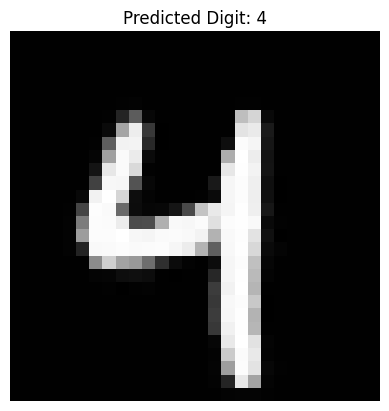

Model Prediction: 4


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def predict_custom_image(image_path):
    # Read and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("Error: Image not loaded properly.")
        return

    img = cv2.resize(img, (28, 28))
    img = cv2.bitwise_not(img)  # Invert to match MNIST black background
    img = img / 255.0
    img = img.reshape(1, 28, 28, 1)

    # Load model
    model = tf.keras.models.load_model("cnn_mnist_model.h5")

    # Predict
    prediction = model.predict(img)
    predicted_digit = np.argmax(prediction)

    # Show image and prediction
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted Digit: {predicted_digit}")
    plt.axis('off')
    plt.show()

    print(f"Model Prediction: {predicted_digit}")

# Use this only AFTER you upload the image
predict_custom_image("my_digit.png")  # ← change filename if needed


In [ ]:
!pip install streamlit opencv-python-headless pyngrok streamlit-drawable-canvas



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
import tensorflow as tf
from streamlit_drawable_canvas import st_canvas

# Load model
model = tf.keras.models.load_model("cnn_mnist_model.h5")

st.title("🖌️ Handwritten Digit Recognition")

# Create a canvas
canvas_result = st_canvas(
    fill_color="white",
    stroke_width=20,
    stroke_color="black",
    background_color="white",
    height=280,
    width=280,
    drawing_mode="freedraw",
    key="canvas"
)

if canvas_result.image_data is not None:
    img = canvas_result.image_data
    img = cv2.cvtColor(img.astype("uint8"), cv2.COLOR_RGBA2GRAY)
    img = cv2.bitwise_not(img)  # Invert so background is black and digit is white

    # Threshold to remove noise
    _, img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

    # Find bounding box of the digit
    coords = cv2.findNonZero(img)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        digit = img[y:y+h, x:x+w]  # Crop around the digit

        # Resize while maintaining aspect ratio
        margin = 20  # Add margin for better centering
        square_size = max(w, h) + margin
        square = np.zeros((square_size, square_size), dtype=np.uint8)  # Black background

        # Compute center offset
        x_offset = (square_size - w) // 2
        y_offset = (square_size - h) // 2

        square[y_offset:y_offset+h, x_offset:x_offset+w] = digit

        # Resize to 28x28
        final_img = cv2.resize(square, (28, 28))

        # Normalize and reshape
        final_img = final_img / 255.0
        final_img = final_img.reshape(1, 28, 28, 1)

        if st.button("🔍 Predict"):
            pred = model.predict(final_img)
            digit_pred = np.argmax(pred)
            st.success(f"✅ Predicted Digit: {digit_pred}")
            st.image(final_img.reshape(28, 28), width=150, caption="Processed Input")



Overwriting app.py


In [ ]:
from pyngrok import ngrok
!streamlit run app.py &>/content/log.txt &
url = ngrok.connect(8501) # Changed from port=8501 to just 8501
print("🌐 Open this URL in your browser to use the app:")
print(url)

PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: Your account may not run more than 3 tunnels over a single ngrok agent session.\nThe tunnels already running on this session are:\ntn_30xAEwhuZ02J5LUk281tgA44DXs, tn_30x984ylt605a7xeoGjbBtzVV5O, tn_30x9cYigyJQsr48awCytc5OaVws\n\r\n\r\nERR_NGROK_324\r\n"}}


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload cnn_mnist_model.h5


Saving cnn_mnist_model.h5 to cnn_mnist_model (1).h5


In [ ]:
import os
print("cnn_mnist_model.h5" in os.listdir())  # Should return True


True


In [ ]:
model = tf.keras.models.load_model("cnn_mnist_model.h5")
